## Supervised Learning
## Project: Finding Donors for *CharityML*
- Python 3.7

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. 

>> Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than `$50,000`. 

This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [91]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd
import seaborn as sns
import visuals as vs

%matplotlib inline

from time import time
from IPython.display import display 

In [92]:
data = pd.read_csv("census.csv")
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


In [93]:
data.income.value_counts()

<=50K    34014
>50K     11208
Name: income, dtype: int64

### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [94]:
n_records = data.shape[0]  # total # of records

In [95]:
n_greater_50k = data[data['income']== '>50K'].shape[0]  # income is more than $50,000

In [96]:
n_at_most_50k = data[data['income']== '<=50K'].shape[0] # income is at most $50,000

In [97]:
greater_percent = round(n_greater_50k / n_records*100,2)  # % income is more than $50,000

In [98]:
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


**Featureset Exploration**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

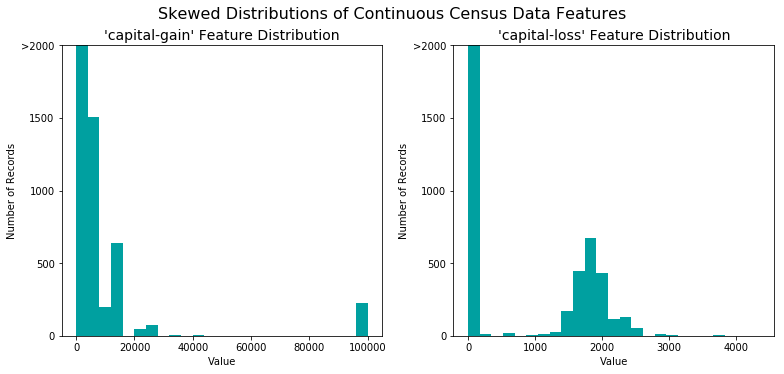

In [99]:
income_raw = data['income']                           # Split the data into features and target label
features_raw = data.drop('income', axis = 1)
vs.distribution(data)                                 # Visualize skewed continuous features of original data


For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

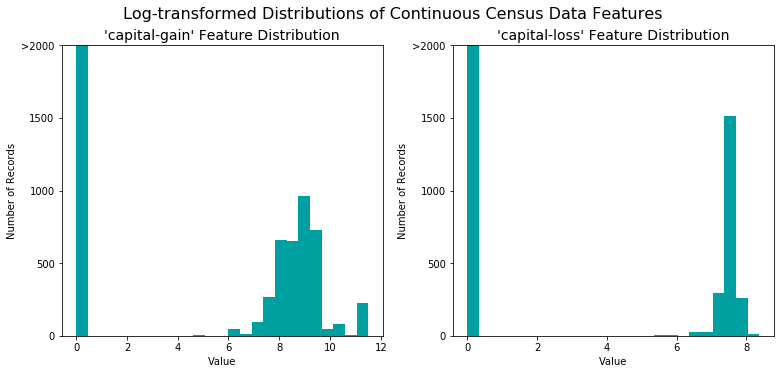

In [100]:
skewed = ['capital-gain', 'capital-loss']                   # log-transform skewed features
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [101]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [102]:
data.columns

Index(['age', 'workclass', 'education_level', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [120]:
features_final = pd.get_dummies(features_log_minmax_transform) # one-hot encode w/ pandas.get_dummies() 

income = data.income.map({'<=50K': 0, '>50K': 1})  # encode income to 0 and 1

encoded = list(features_final.columns)
print("{} total features after one-hot encoding".format(len(encoded)))

103 total features after one-hot encoding


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [104]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_final,    # split 'features' and 'income' 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


In [105]:
list(X_train)

['age',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'workclass_ Federal-gov',
 'workclass_ Local-gov',
 'workclass_ Private',
 'workclass_ Self-emp-inc',
 'workclass_ Self-emp-not-inc',
 'workclass_ State-gov',
 'workclass_ Without-pay',
 'education_level_ 10th',
 'education_level_ 11th',
 'education_level_ 12th',
 'education_level_ 1st-4th',
 'education_level_ 5th-6th',
 'education_level_ 7th-8th',
 'education_level_ 9th',
 'education_level_ Assoc-acdm',
 'education_level_ Assoc-voc',
 'education_level_ Bachelors',
 'education_level_ Doctorate',
 'education_level_ HS-grad',
 'education_level_ Masters',
 'education_level_ Preschool',
 'education_level_ Prof-school',
 'education_level_ Some-college',
 'marital-status_ Divorced',
 'marital-status_ Married-AF-spouse',
 'marital-status_ Married-civ-spouse',
 'marital-status_ Married-spouse-absent',
 'marital-status_ Never-married',
 'marital-status_ Separated',
 'marital-status_ Widowed',
 'occupation_ Adm-cleri

----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. 

>> Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most `$50,000`, and those who make more), it's clear most individuals do not make more than `$50,000`. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than `$50,000`"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than `$50,000`, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

**Precision** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

**Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
1. If we chose a model that always predicted an individual made more than 50,000, what would that model's accuracy and F-score be on this dataset? 

**Note** the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

**ANSWER:** 
    
   If we chose a model that always predicted if a person made more than 50,000, then the Accuracy would not include the real True Negatives because we are classifying everything as persons who make more than 50k, so it would become the same as our Precision which would be True Positives/(True Positives + False Positives) and denominator is total number of results in total. Conversely, the Recall score (True Positives/(True Positives + False Negatives)) is affected as well since we have no False Negatives and results in 1. Lastly, the F score would results in a 1 because the F score is just 2 times the Precision times Recall divided by Precision plus Recall.

In [106]:
'''
tp = np.sum(income)         # counting 1s --> naive case. 
fp = income.count() - TP    # specific to the naive case

tn = 0 # no predicted negatives in the naive case
fn = 0 # no predicted negatives in the naive case
'''

tp = np.sum(y_train==1)
tn = 0

fp = y_train.count() -tp
fn = 0 

accuracy =   (tp + tn)  / len(y_train)  
recall =     tp / (tp + fn) 
precision =  tp / (tp + fp) 

beta = 0.5 
fscore =  (1+beta) * (precision*recall) / ((beta*precision)+recall)

print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2489, F-score: 0.3320]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**ANSWER:**

>> A machine learning algorithms most basic task is to apply some mathematical method to a set of data points in the form of regression, classification and or clustering and to start, thanks to this [outline](https://scikit-learn.org/stable/supervised_learning.html) we can see how each of these models all have the capability for regression and classification. Regression considers continuous and typically numerical data, and require “ground truth” data which we have in this case, but when looking at our outcome, I see regression is not the algorithm to go with, rather classification would be the better option because we are looking for a model to best classify two outcomes, users with either more than 50k or less than 50k which is very binary and perfect for classification. In fact, one type of logistic regression is called, “Binary Logistic Regression”. 


1. **Decisions Trees (DT):** can work as a regression or classification model. In both cases, you start with a root binary feature condition, and based on the answer on that condition, you “branch” out to either a left leaf or a right leaf, until you reach a final outcome. The leaves can be considered as labels and branches as features. When using a DT as a classification model the prediction will be discrete, whereas, in a regression model, the prediction could be continuous or a real number[4]. 

    - Real world applications of a DT model would be any type of recommendation system. 
    - The strengths of a DT model are that of cases in which the data is smaller with fewer features and non-linear. DTs are used in non-linear decision making, very easy to implement and to understand in handling both categorical and numerical data[6].
    - The weaknesses of a DT model come to play when you’re working with a large dataset like ours with over 103 features. DT’s are commonly overfitting because of the branch like nature that continues to split on each feature condition until a conclusion is made. You could specify depth and layers before building the model as a precaution. 
    - Given we have been tasked to construct a model that accurately predicts whether a person makes more than `50k` which is already a discrete feature in our dataset, using a classification DT may be a potential learner as DTs can work with classification based modeling. To begin with a classification algorithm for this case, we would “calculate potential vertical or horizontal splits for each column where we first calculate the entropy of each of the labels/ leaves, then, calculate the information gain and pick the largest one” [8]. The only problem might be in the complexity of considering over 103 encoded features. 


2. **Logistic Regression (LR):** algorithm is used mostly for predicting a categorical feature with ONLY two possible outcomes. Predictions can be mapped to 0 or 1 and can be “regularized”. 
    - Real world use cases for the LR algorithm are vast, in that it's one of the most commonly used ML algorithms because of it's simpleness, and can even be used as a baseline in determining the performance of other more complex algorithms.[3]
    - Strengths of LRs are probabilistic and regularization can be used to avoid overfitting. LRs can also be integrated with “stochastic gradient descent”[2]    
    - Weaknesses of LRs “can underperform with multi or non-linear decision boundaries, and can not be flexible to capture complex relationships”[2]. Decision boundaries can be tuned to a threshold to help fit the data.
    - Given our dataset, this model is a good candidate because we have many features to consider and can use as a binary indicator for the model to train on.


3. **Ensemble Methods (EM)** are used when we are combining weak learners to create a strong learner.  The two factors we look at with ensemble methods are bias and variance.  A high bias generally means the line doesn’t fit well to the data as in for example, linear regression but, this also means it has a low variance. A high variance means the model memorizes in a way all the data points in the dataset as in how a decision tree would branch out given the result of each feature condition. This also means a decision tree has a low bias. In conclusion, the result is an ensemble method that aims to minimize bias and variance which we can do by using a random forest algorithm [7]. Ensemble methods like a Random Forest (FR) or Gradient Boosting Trees (GBM) use aspects of DTs. Ensemble methods can be competitively intense, and add to memory constraints. However, assist with this bias/variance trade off which allow for further tuning and testing. Boosting helps to reduce bias, so this would be used if our model has a high bias, but we have to ensure our data is not noisy in order for boosting to work well. While Bagging, or Bootstrap Aggregating, tends to reduce variance so this is useful if we are experiencing a high variance outcome.

    - Real world applications from what I’m reading, it’s typical to have RFs and GBMs used together but, GBMs are used for anomaly detection (credit card fraud, DNA sequences). Real world RF applications are anything related to “multi-class object detection in computer vision or bioinformatics”[1] of which requires ability to handle large amounts of data, 
    - Strengths of RFs are the “randomness” and makes it less likely to overfit. RFs are easier to tune than GBMs with only two parameters # of trees, and # of nodes. Strengths of GBM is that "it builds a tree at a time in that each new tree corrects errors made by previous tree"[1] 
    - Weaknesses of GBMs are tendency to overfit if data is noisy and harder to tune parameters than RFs. Weaknesses of RFs tend to be lots of trees can make the algorithm slow and RFs bias for attributes with more levels.[1]
    - Given our dataset, random forest would work great in that we have so many features to consider getting a random sampling using bootstrapping and targeting only a subset of these features at a time.
    
    
    
4. **Stochastic Gradient Descent Classifier (SGD):** works well with linear classifiers
    - Real world use cases for SGD are related to text classification and NLP.
    - Strengths of SGD are rather instead of a normal gradient descent where the algorithm is computing a prediction for every single data point in the data set with the SGD, the algorithm is computing the gradient and updates a weight matrix on batches of data instead.
    - Weaknesses of the SGD is that it might produce more “noise”[9] and requires hyperparameters as a regularization, and is sensitive to feature scaling[9]. 
    - Given our use SGDs may not be as resourceful.


5. **SVM**: can be used for classification or regression problems as SVR or SVC by finding the best decision boundary to separate the data, and to “find the smallest distance between the data points and the decision boundary to be as large as possible” utilizing “margins” 
   - Real world applications include face detection, image classification, and other computer vision applications. 
   - Strengths are SVMs can model non-linear decision boundaries and the "kernels"[10] allow for customization and don’t always “over-fit” given their dimensional space.
    - Weaknesses are that SVMs take up a lot of memory, and typically don’t work well with larger datasets. RFs can be an alternative. 
    - Given our large dataset, we will pass on this model.

**CITATIONS:**
1. A. Ravanshad, Medium, 'Gradient Boosting vs Random Forest', April 27, 2018, Reference: https://medium.com/@aravanshad/gradient-boosting-versus-random-forest-cfa3fa8f0d80
2. Elite Data Science, “Modern Machine Learning Algorithms: Strengths and Weaknesses”, Reference: https://elitedatascience.com/machine-learning-algorithms
3. N.S. Chauhan, "Real World Implementation of Logistic Regression", March 11, 2019, Reference: https://towardsdatascience.com/real-world-implementation-of-logistic-regression-5136cefb8125
4. Wikipedia, Reference: https://en.wikipedia.org/wiki/Decision_tree_learning
6. Hackerearth.com, “Decision Tree”, Reference: https://www.hackerearth.com/practice/machine-learning/machine-learning-algorithms/ml-decision-tree/tutorial/ 
7. Udacity, Maching Learning with Tensorflow Nanodegree, “Ensembles”, Reference: Lesson 7, Video 2
8. Udacity, Maching Learning with Tensorflow Nanodegree, “Maximizing Information Gain”, Reference: Lesson 4, Video 15 
9. A. Rosebrock, PyImageSearch, “Stochastic Gradient Descent (SGD) with Python”, October 17, 2016, Reference: https://www.pyimagesearch.com/2016/10/17/stochastic-gradient-descent-sgd-with-python/  
10. Z. Zhang, Towards Data Science, “Support Vector Machine Explained”, July 30, 2019, References: https://towardsdatascience.com/support-vector-machine-explained-8bfef2f17e71

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [107]:
from sklearn.metrics import accuracy_score, fbeta_score, f1_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    results = {}
    
    # TODO: Fit the learner using slicing 'sample_size' -> .fit(training_features[:], training_labels[:])
    start = time() 
    learner =learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() 
    
    results['train_time'] = start + end
        
    # get the predictions on the test set(X_test), 
    # then get predictions on the first 300 training samples(X_train) using .predict()
    
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() 
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = start + end
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train[:300])
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train[:300], beta=0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = f1_score(predictions_test, y_test) 
    
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size)) 
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


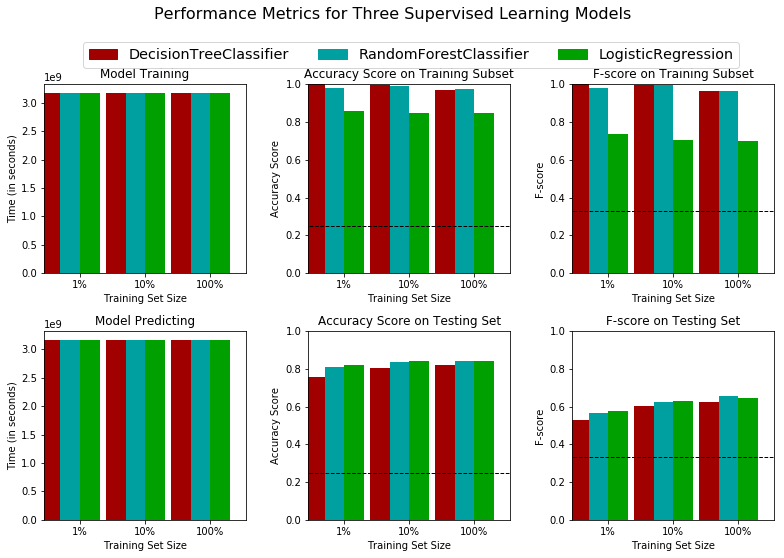

In [108]:
# import the 3 supervised learning models from sklearn DTs, EMs, and LR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier 
from sklearn.tree import DecisionTreeClassifier

clf_A = DecisionTreeClassifier(random_state=42)
clf_B = RandomForestClassifier(random_state=42) # AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=2), n_estimators = 4) 
clf_C = LogisticRegression(random_state=42)

# calculate the number of samples for 1%, 10%, and 100% of the training data
# 1. reference: https://stackoverflow.com/questions/43777243/how-to-split-a-dataframe-in-pandas-in-predefined-percentages
# example: a, b, c = np.split(df, [int(.2*len(df)), int(.5*len(df))])

samples_100 = int(len(y_train)) 
samples_10 = int(.10 * len(y_train))  # [1]
samples_1 = int(.01 * len(y_train))   # [1]

results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [121]:
results['RandomForestClassifier'] # sample our results dict

{0: {'train_time': 3167246222.3790693,
  'pred_time': 3167246222.412548,
  'acc_train': 0.97999999999999998,
  'acc_test': 0.80829187396351576,
  'f_train': 0.98214285714285721,
  'f_test': 0.56519558676028081},
 1: {'train_time': 3167246222.493965,
  'pred_time': 3167246222.5723934,
  'acc_train': 0.99333333333333329,
  'acc_test': 0.83360972913211717,
  'f_train': 0.99431818181818166,
  'f_test': 0.62309040821437511},
 2: {'train_time': 3167246223.352855,
  'pred_time': 3167246224.1376534,
  'acc_train': 0.97333333333333338,
  'acc_test': 0.84311774461028188,
  'f_train': 0.96726190476190466,
  'f_test': 0.65666586015001216}}

In [122]:
# create 3 dataframes from results dict and then use concat to merge

rf = results['RandomForestClassifier']
rf_df = pd.DataFrame.from_dict(rf, orient='index').rename(index= {0 : '1%', 1 : '10%', 2 : '100%'})
rf_df['time_diff'] = abs(rf_df['train_time'] -rf_df['pred_time'])

dt = results['DecisionTreeClassifier']
dt_df = pd.DataFrame.from_dict(dt, orient='index').rename(index= {0 : '1%', 1 : '10%', 2 : '100%'})
dt_df['time_diff'] = abs(dt_df['train_time'] - dt_df['pred_time'])

lr = results['LogisticRegression']
lr_df = pd.DataFrame.from_dict(lr, orient='index').rename(index= {0 : '1%', 1 : '10%', 2 : '100%'})
lr_df['time_diff'] = abs(lr_df['train_time'] - lr_df['pred_time'])

all_results = pd.concat([rf_df, dt_df, lr_df], axis=0 , 
                        keys=['random forest', 'decision tree', 'logistic regression'], 
                        names=['model', '% of data'])

# create heatmap of df results

cm = sns.light_palette("yellow", as_cmap=True)
all_results.style.background_gradient(cmap=cm)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

Look at the graph at the bottom left from the cell above and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:

* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer**: 

   The F score means that we are looking at a “harmonic” mean of our precision and recall. Specifically, we are  multiplying 2 by the numerator of precision times recall divided by our denominator of precision + recall. That “score” is a better indicator of how well the model did in terms of precision and recall as just taking the average is not a good indicator as is if p & r are very low. The harmonic mean is smaller than the arithmetic mean and that way it will be closer to the smallest number between precision and recall, which is more useful. So if you have a very low F1 score, this will help to alert you that either precision or recall is a lower number.  

```
F1 Score = 2 * (Precision+Recall/Precision∗Recall)
```

   From the graphs above we can see the highest F1 score for the test set when using 100% of the testing data, was from our RandomForestClassifier followed by, Logistic Regression and then Decision Trees. However, when we look at prediction and training time, the RandomForestClassifier was the most time consuming when using 100% of the testing data whereas, LogisticRegression was the least. Finally in terms of suitability of our data to either of these models, would be that our RandomForestClassifier is best suited for handling the binary like classification required outcome of predicting persons income and it can handle the number of features we have while as noted initially albeit the prediction times may be slower. Given the RF is seen as a part of an Ensemble Method we can fine tune our results adding in a boosting algorithm like Gradient Boosting or Ada Boosting.

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

**Answer:** 

   The model chosen for this project is a RandomForestClassifier which is part of the Ensembles methods sklearn library. Ensembles methods essentially coordinate the models to be used together such that the predictions of the weaker learners, "or several base esimators built with a learning algorithm, improve generalizability over a single estimator [1]. There are two groups of ensemble methods, those which use averaging methods, and those using boosting methods. The RandomForestClassifier uses an averaging which means the estimators are built and then their predictions are averaged. 

   The RandomForestClassifier main feature is "randomization" and like bootstrapping from data analysis techniques, here we learn, "each tree in the ensemble is built from a sample drawn with replacement" [1] so, the best split of the data "is found either from all input features or a random subset of size max features" [1]. The best aspect to this classifier is that you reduce variance. A great article, summarized the process of how the algorithm works with this description, "... with a set of decision trees from randomly selected subset of training data, it aggregates the votes from different decision trees to decide the final class of the test object" [2]


**CITATIONS:** 
1. Sklearn, "1.11 Ensemble methods", Reference: https://scikit-learn.org/stable/modules/ensemble.html
2. S. Patel, Medium, "Chapter 5: Random Forest Classifier", May 18, 2017, Reference: https://medium.com/machine-learning-101/chapter-5-random-forest-classifier-56dc7425c3e1

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

#### Understanding Random Forest hyperparameters: 

```
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
```

```
Check the list of available parameters with `estimator.get_params().keys()
```


In [124]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

clf = RandomForestClassifier() 

rf_parameters = {'n_estimators': [500],   # random forest parameters 
              'max_depth': [2,4,6,8,10], 
              'min_samples_split': [4], 
              'min_samples_leaf': [2]}

# ada_parameters = {'n_estimators': [50, 100],   # ada boost parameters
#               'learning_rate': [0.1, 0.5, 1],
#               'random_state': [42]}

scorer = make_scorer(fbeta_score,beta=0.5)

grid_obj = GridSearchCV(clf, rf_parameters, scoring=scorer) 

grid_fit = grid_obj.fit(X_train, y_train)

best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8347
F-score on testing data: 0.6646

Optimized Model
------
Final accuracy score on the testing data: 0.8557
Final F-score on the testing data: 0.7280


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**? 

#### Results:

|     Metric     | Unoptimized Model | Optimized Model | Unopt/Opt Diff | Naive Bayes  | N Diff |
| :------------: | :---------------: | :-------------: | :------------: | :----------: | :-----:|
| Accuracy Score |  0.844            |  0.855          |  0.011         |  0.249       |  0.606 |
| F-score        |  0.686            |  0.728          |  0.042         |  0.332       |  0.396 |


#### Viewing diffs between accuracy, f_score and naive scores

In [112]:
acc_diff = 0.855- 0.844
f_diff = 0.728- 0.686 
print((format(acc_diff,'.3f'), format(f_diff, '.3f')))

naive_acc_diff = 0.855-0.249
naive_f_diff = 0.728- 0.332
print((format(naive_acc_diff,'.3f'), format(naive_f_diff, '.3f')))

('0.011', '0.042')
('0.606', '0.396')


**Answer:**
1. **What is your optimized model's accuracy and F-score on the testing data?:** 

    * The RandomForestClassifier model's optimized _accuracy score_ on the testing data was 85% while the _F-score_ was 72%
    
    
2. **Are these scores better or worse than the unoptimized model?:** 

    * These scores are only "slightly" better than the optimized model, with accuracy a 0.11 or 1.1% increase and f score a 0.42 or 4.2% increase.  
    
    
3. **How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in Question 1?:**

    * The Naive Bayes predictor used from earlier in the first question had an accuracy of 0.249 and f score of 0.33 so the increase from the optimized model was 60% on accuracy and 39% on f score.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

In [113]:
data.columns

Index(['age', 'workclass', 'education_level', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

**Answer:**
    The following top five of the thirteen features from our dataset, are listed below with reasons for imporance and why they were chosen. 
    
   1. **Workclass** _[Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked]_:
       - Working class as unfortunate as it may sound in that we put people into "classes" of working groups which seem as if they are static are a very important factor for achieving a salary level exceeding 50,000 annually. For example, those who may have obtained wealth privately from their family inheritence for example, have an enormous advantage over those who are working in the government or employed. Quantifying this advantage would require further analysis of our national salary data but, from experience alone in the workforce it can be exponential which speaks to the severity of predictiveness on these "classes". This was chosen as the top feature because of the inflexibility this status or "label" provides and when one does change their working class, it's usually or typically for a longer term. 
       
       
   2. **Education** _[Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool]_:
       - Education level is another important feature in that when receiving "higher education" from a Masters, or Doctorate, there is an advantage to these groups of people that is different from what a Bachelors or less might recieve. Again, being able to quantify this "advantage" would require more analysis but, when you are in the workforce and see others who seem to "have" this "higher knowledge" whether it's in meetings, or written memos you realize they have more responsibility for a reason. This is also now changing because of free education online however, the statistical significance remains to be seen. This was chosen as the second top feature because it's one of the most significant decisions a person makes in their life mentally and monetarily but, has high reward albeit debt risk.
       
       
   
   3. **capital-loss** _[continuous]_: 
       - The term capital loss refers to the loss "incurred when a capital asset such as investment or real estate, decreases in value. This loss is not realized until the asset is sold for a price that is lower than its original price.[1] This would be a positive indicator for the model that this person is not viable candidate to donate. This was chosen as the third top feature because of the negative immediate impact it could have on the persons monetary evaluation or assessment by the model. 
   
   
   
   
   4. **capital-gain** _[continuous]_:
       - The term capital gain "is a rise in the value of a capital asset which can be real estate or an investment, that gives a higher worth than the purchase price.[2] This would be a positive indicator for the model that this person may be a viable candidate to donate given they are seeing increase in their income or overall evaluation. The reason this was chosen as the fourth top feature is because of the most positive impact it can has on the assessment by the model. 
   
   
   
  
   5. **sex** _[Male, Female]_:
       - Unfortunately, I do believe gender is a factor in determining whether a person is able or unable to achieve a higher level of income. This was chosen as the last top feature because it is not completely 100% an indicator but, can have significance on that threshold or rather the difference between as little as a 10,000 gap between male and female or at most a 50,000 or more.
       

**CITATIONS:** 
1. J. Chen, _"Capital Loss"_, Investopedia, Reference: https://www.investopedia.com/terms/c/capitalloss.asp
2.  J. Chen, _"Capital Gain"_, Investopedia, Reference: https://www.investopedia.com/terms/c/capitalgain.asp

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

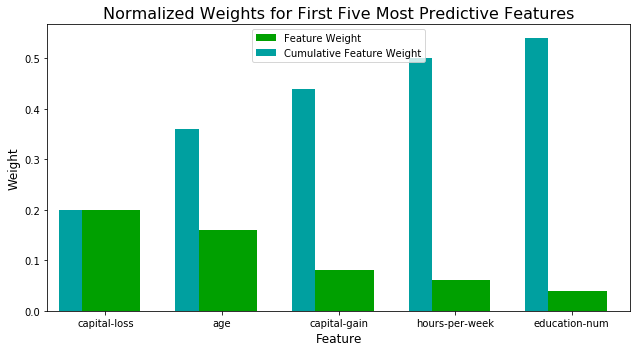

In [114]:
# train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier().fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_ 

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

1. **How do these five features compare to the five features you discussed in Question 6?**
    - I received a 2/3 in comparison to the feature importance extraction using the AdaBoostClassifier(). 
    
    
2. **If you were close to the same answer, how does this visualization confirm your thoughts?**
    - The capital loss and capital gain were exactly what I chose however, in terms of ranking, they were lower on the list at 3 and 4 out of 5. This visualization helps me to see that capital loss is actually more important in fact the most important feature to determining income level. I did note education as the 2 on my list so the "education num" I believe refers to the count of education levels you've received so that was similar. 
    
    
3. **If you were not close, why do you think these features are more relevant?**
    - I was not close at all with regard to "age" or "hours per week" however, and I still feel working class is an indicator however, I realize now maybe it's not as much "weight" of an indicator than I thought. I suppose "age" is a factor in which you tend to increase your salary as you age however, I still believe "gender or sex" can be that difference of a small gap or big gap that is significant enough to help the model.  

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [115]:
from sklearn.base import clone

# reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8553
F-score on testing data: 0.7271

Final Model trained on reduced data
------
Accuracy on testing data: 0.8322
F-score on testing data: 0.6729


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

In [116]:
acc_diff_final = 0.855- 0.8320
f_diff_final = 0.728 - 0.6719
print((format(acc_diff,'.3f'), format(f_diff, '.3f')))

('0.011', '0.042')


In [117]:
ada_rf_acc_diff = 0.86 - 0.855
ada_rf_f_diff = 0.731 - 0.728
print((format(acc_diff,'.3f'), format(f_diff, '.3f')))

('0.011', '0.042')


**Answer:**

1. **How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?**
    - Unfortunately, the f score on the final model using reduced data was less than the Random Forest Classifier optimized model on full data and there was no change on the final model full data comparison. 
2. **If training time was a factor, would you consider using the reduced data as your training set?**
    - No, I would not use the reduced data as a training set, and I already tested the AdaBoostClassifier as another potential model in place of the RandomForestClassifier which had a optimized model accuracy score of 86% and f score of 73% however, this was just about the same of an increase as we saw earlier, and the negative was the AdaBoostClassifier train and prediction time was two times as longer as both the LogisticRegressionClassifier or the DecisionTreeClassifier so that may not be the best solution after all. 

## Before You Submit
You will also need run the following in order to convert the Jupyter notebook into HTML, so that your submission will include both files.

In [125]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook finding_donors.ipynb to html',
 '[NbConvertApp] Writing 544518 bytes to finding_donors.html']